# Get This Notebook

Clik on `file` (upper left corner) and choose from the dropdown the option, which you prefer:
- `Save a copy in Drive` to add the notebook to your Google Drive (where you can access it via Google Colab)
- `Download .ipynb` to download the Notebook as a Jupyter Notebook, which you can run from your local machine

# Before we start: Setup

Before we start coding out the solution, make sure you have all the prerequisite Python packages. Run the following code to install the versions of the packages you will be needing for this Notebook.

In [1]:
# Install necessary pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas==1.0.5 matplotlib==3.2.2 seaborn==0.10.1 numpy==1.18.5 scikit-learn==0.22.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 19.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Problem Description: Predict customers subscribing to a term deposit

You are given a dataset with historical information about the telemarketing activities of a Portuguese bank. Your job is to build a logistic regression model, which can predict whether a customer subscribed to a term deposit based on different client attributes.

The dataset can be [found here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).
</br>
</br>

### Attribute Information

**bank client data**:</br>
1 - age (numeric)</br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')</br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)</br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')</br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')</br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')</br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')</br></br>
**related with the last contact of the current campaign:**</br>
8 - contact: contact communication type (categorical: 'cellular','telephone')</br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')</br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')</br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</br>
**other attributes:**</br>
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)</br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)</br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)</br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')</br>

### Output (target) variable
16 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# STEP 1: Load & inspect data

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas as pd

data_archive_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

# uzip the directory in memory and load bank-full.csv into a pandas dataframe
resp = urlopen(data_archive_url)
zipfile = ZipFile(BytesIO(resp.read()))
df = pd.read_csv(zipfile.open('bank-full.csv'), sep=';')

# check the first 5 rows to get a feeling of the data
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# STEP 2: Exploratory Data Analysis (EDA) & Data Cleaning
Inspect and visualize the data to notice trends.

Clean the data according to [best practices](https://www.keboola.com/blog/the-ultimate-guide-to-data-cleaning).

But before we can do any analysis, we need to recode categorical columns to numerical ones, so we can more clearly analyze them.

In [ ]:
# start by recoding columns with 'yes' and 'no' values into 0 and 1
# this affects 'y', the target variable, and the columns 'default', 'housing', and 'loan'
df.replace(['no', 'yes'], [0, 1], inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [ ]:
# drop the 'duration' column because it is too correlated to the outcome target
df.drop(['duration'], axis=1, inplace=True)

In [ ]:
# one-hot-encode categorical columns
def one_hot_encode(_dataframe, list_of_columns_to_one_hot_encode):
    for column in list_of_columns_to_one_hot_encode:
        # one-hot-encode this column
        one_hot_encoded_values = pd.get_dummies(_dataframe[column], prefix=column)

        # join the one-hot-encoded values with original dataframe
        _dataframe = pd.concat([_dataframe, one_hot_encoded_values], axis=1)

        # drop the original column, we don't need it anymore
        _dataframe.drop([column], axis=1, inplace=True)

    return _dataframe

# get a list of all columns with categorical values
categorical_columns = df.select_dtypes(exclude=['int', 'float']).columns

df = one_hot_encode(df, categorical_columns)
df.head()

,age,default,balance,housing,loan,day,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Now we can look at descriptive statistics.

In [ ]:
# get descriptive statistics for each column/feature
df.describe(include='all')

,age,default,balance,housing,loan,day,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.00000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,2.763841,40.197828,0.580323,0.116985,0.114375,0.215257,0.032890,0.027427,0.209197,0.050076,0.034925,0.09188,0.020747,0.168034,0.028820,0.006370,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.041074,0.647741,0.064276,0.287983,0.064851,0.138174,0.004733,0.058592,0.031032,0.152507,0.118135,0.010551,0.304483,0.087810,0.016323,0.012807,0.108403,0.040698,0.033421,0.817478
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,3.098021,100.128746,2.303441,0.321406,0.318269,0.411005,0.178351,0.163326,0.406740,0.218105,0.183592,0.28886,0.142538,0.373901,0.167303,0.079559,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.198464,0.477680,0.245247,0.452828,0.246266,0.345087,0.068637,0.234862,0.173407,0.359516,0.322771,0.102174,0.460193,0.283022,0.126718,0.112441,0.310892,0.197592,0.179735,0.386278
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,1

The information above is useful to understand the top down statistics of data (e.g. mean, median, standard deviation), but this works even better, if we visualize the data.

Before we visualize it, though, let us clean it a bit.

Check if there are any **missing values** within the dataframe.

In [ ]:
# count the number of rows with missing values per column
df.isna().sum()

age                    0
default                0
balance                0
housing                0
loan                   0
day                    0
campaign               0
pdays                  0
previous               0
y                      0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
education_primary      0
education_secondary    0
education_tertiary     0
education_unknown      0
contact_cellular       0
contact_telephone      0
contact_unknown        0
month_apr              0
month_aug              0
month_dec              0
month_feb              0
month_jan              0
month_jul              0
month_jun              0
month_mar              0


All good! No information is missing, so we do not have to remove anything at this moment.

For the next step, we check data distribution, and whether there are any **outliers**. We do it by visualizing the data with box plots.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


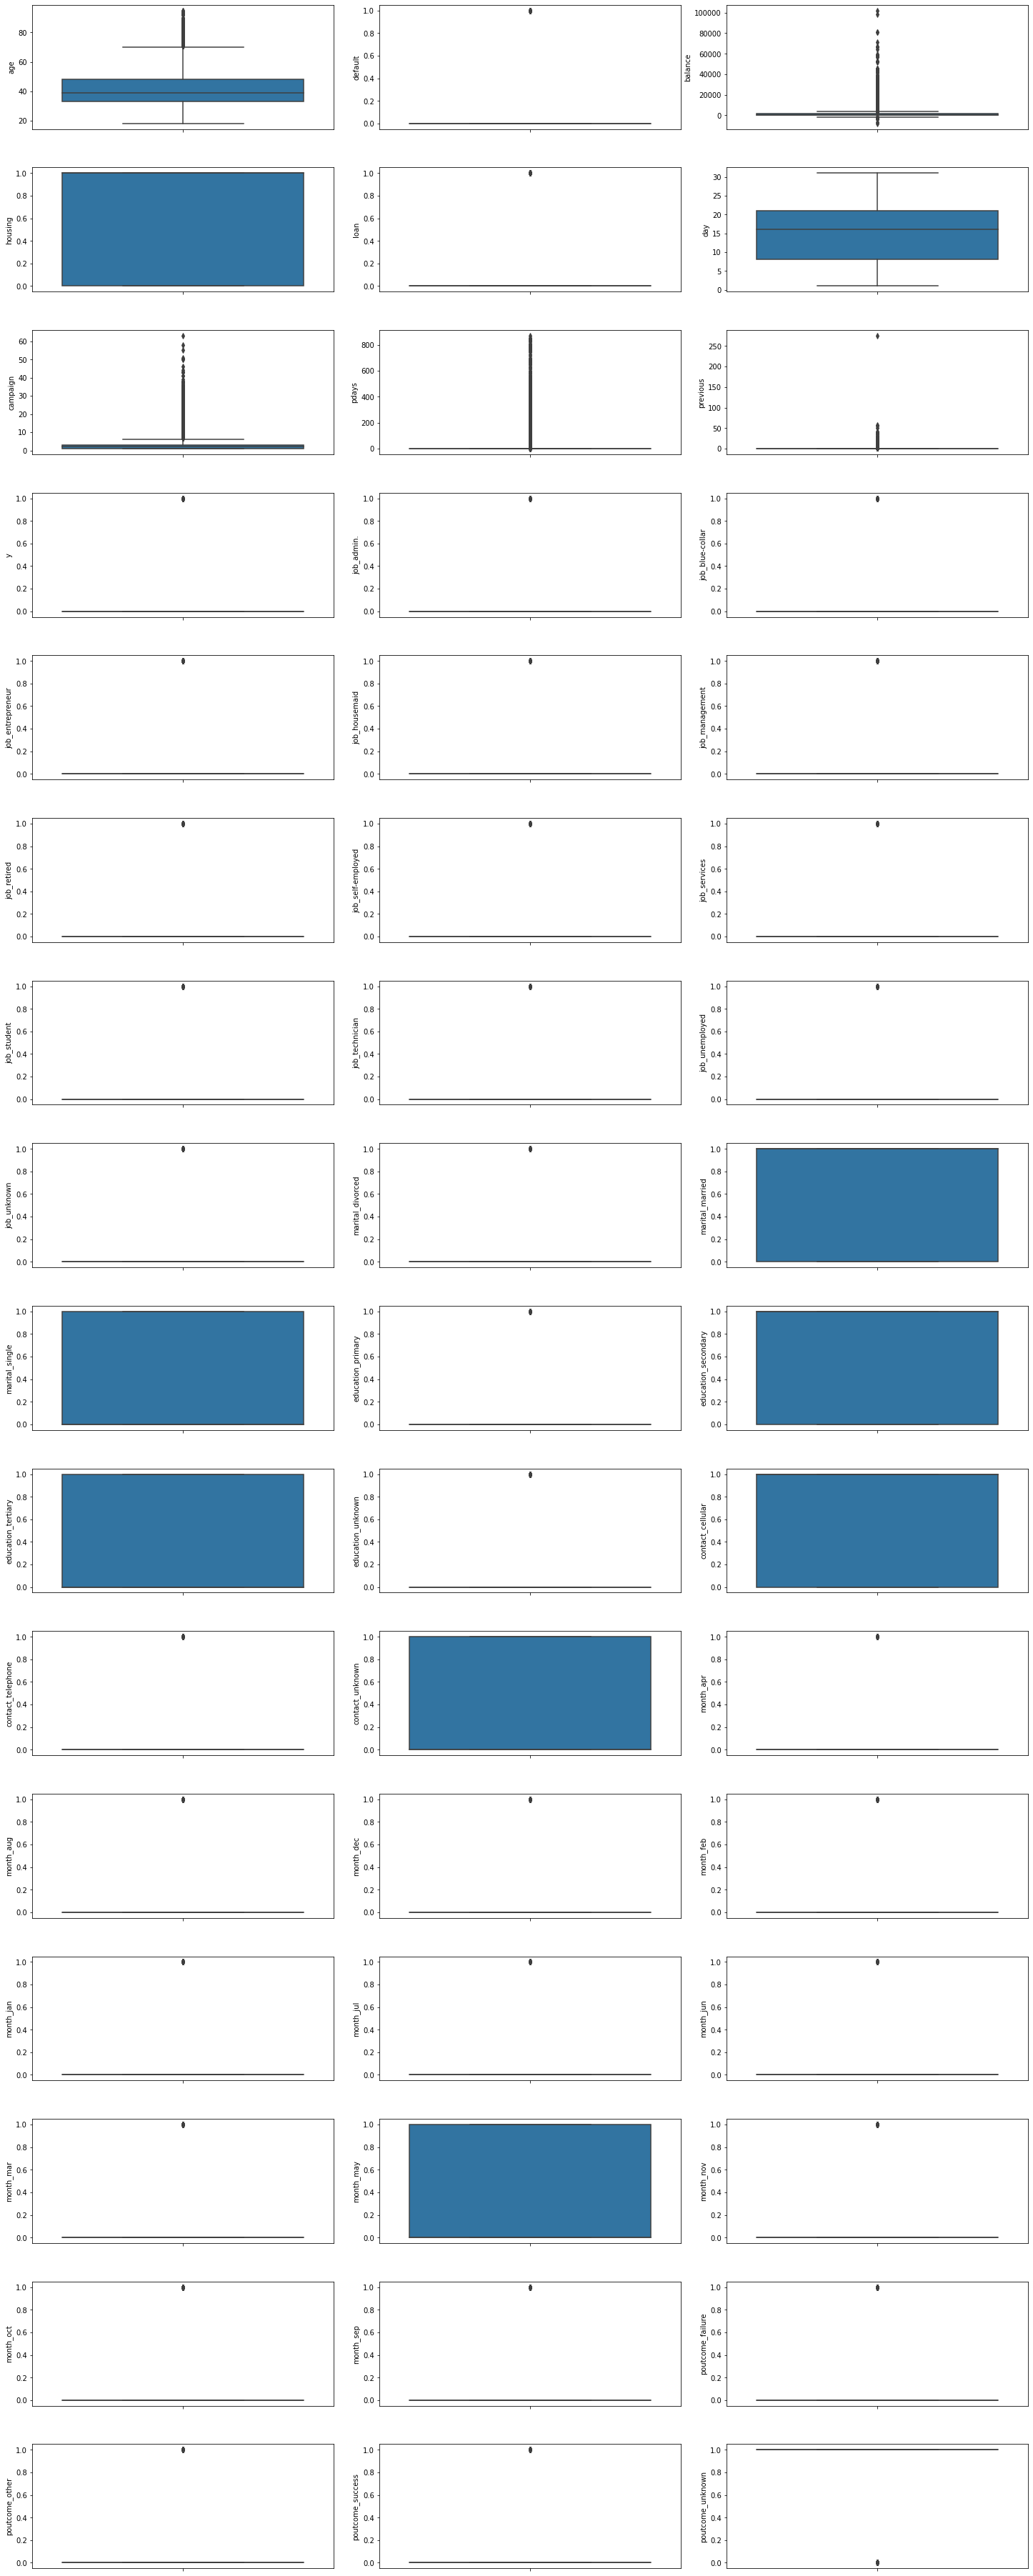

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=16, figsize=(20, 50))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

From the Box plot we can see that the columns 'age', 'balance', and 'campaign' look as if they are not having issues with outliers.

The other columns are hard to analyse, because they are one-hot-encoded. But we can see from the visualization that we have an inbalance between 0s and 1s within columns for almost all binary columns. This is especially relevant for the target column 'y' which shows class imbalance (and will thus affect our analysis).

But before we continue, let us check the **multicollinearity assumption**. As you can remember, linear regression assumes a features are not mutually correlated too strongly.

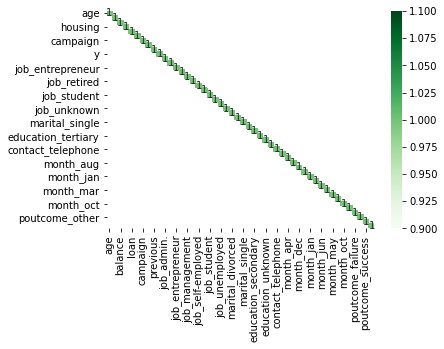

In [ ]:
# build a correlation matrix for the features
corrMatrix = df.corr()

# keep only high correlated items
highCorr = corrMatrix[corrMatrix >= .8]

# plot
sns.heatmap(highCorr, annot=True, cmap="Greens")
plt.show()

The multicollinearity assumption is not violated, because features do not show pair-wise correlation (except with themselves, which is expected).

## STEP 3: Train and evaluate linear regression model

Start by splitting the data into a training set (for model fitting) and a testing set (for model evaluation).

In [ ]:
from sklearn.model_selection import train_test_split

# separate the features (X) from the target (Y)
Y = df['y']
X = df.loc[:, df.columns != 'y']

# divide the data into a training set (for learning) and test set (for validation)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Train the linear regression model.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
trained_model = logreg_model.fit(x_train, y_train)

Use the model to predict new data and evaluate its performance.

In [ ]:
# make predictions
y_predicted = trained_model.predict(x_test)

# rename y_test into y_true for clarity
y_true = y_test

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# get evaluation metrics
accuracy = round(accuracy_score(y_true, y_predicted), 2)
roc_auc = round(roc_auc_score(y_true, y_predicted), 2)

# evaluate performance
print("Model performance:\nAccuracy: {}\nROC AUC: {}".format(accuracy, roc_auc))

Model performance:
Accuracy: 0.89
ROC AUC: 0.58


**Interpretation**: </br>
This is a classic example where accuracy might be deceiving evaluation metric. Why? It seems our model is doing great (Accuracy 89%!). But in reality, the model is performing barely above chance level (aka 58% vs 50% (chance level for binary problem)). Because this is a class imbalance problem, where y is more likely to be 0 than 1, accuracy is an inappropriate metric. ROC AUC, which is not sensitive to class imbalance, is a better one.

# Your turn
Improve the model, to perform better than the baseline above.

A couple of things you can explore:
1. Does the model performance improve once we remove outliers?
2. How does feature normalization affect model performance?
3. Would [regularization](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_path.html) improve the performance of the model?
4. How can you tackle class imbalance ([here are some ideas](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets))?